In [3]:
import gym
import numpy as np
import utils.envs, utils.seed, utils.buffers, utils.torch, utils.common
import torch
import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Deep Q Learning
# Slide 14
# cs.uwaterloo.ca/~ppoupart/teaching/cs885-spring20/slides/cs885-lecture4b.pdf

# Constants
SEEDS = [1,2,3,4,5]
t = utils.torch.TorchHelper()
DEVICE = t.device
OBS_N = 4               # State space size
ACT_N = 2               # Action space size
MINIBATCH_SIZE = 10     # How many examples to sample per train step
GAMMA = 0.99            # Discount factor in episodic reward objective
LEARNING_RATE = 5e-4    # Learning rate for Adam optimizer
TRAIN_AFTER_EPISODES = 10   # Just collect episodes for these many episodes
TRAIN_EPOCHS = 5        # Train for these many epochs every time
BUFSIZE = 10000         # Replay buffer size
EPISODES = 300          # Total number of episodes to learn over
TEST_EPISODES = 1       # Test episodes after every train episode
HIDDEN = 512            # Hidden nodes
TARGET_UPDATE_FREQ = 10 # Target network update frequency
STARTING_EPSILON = 1.0  # Starting epsilon
STEPS_MAX = 10000       # Gradually reduce epsilon over these many steps
EPSILON_END = 0.01      # At the end, keep epsilon at this value

# Global variables
EPSILON = STARTING_EPSILON
Q = None

# Create environment
# Create replay buffer
# Create network for Q(s, a)
# Create target network
# Create optimizer
def create_everything(seed):

    utils.seed.seed(seed)
    env = gym.make("CartPole-v0")
    test_env = gym.make("CartPole-v0")
    buf = utils.buffers.ReplayBuffer(BUFSIZE)
    Q = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    Qt = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    OPT = torch.optim.Adam(Q.parameters(), lr = LEARNING_RATE)
    return env, test_env, buf, Q, Qt, OPT

# Update a target network using a source network
def update(target, source):
    for tp, p in zip(target.parameters(), source.parameters()):
        tp.data.copy_(p.data)

# Create epsilon-greedy policy
def policy(env, obs):

    global EPSILON, Q

    obs = t.f(obs).view(-1, OBS_N)  # Convert to torch tensor
    
    # With probability EPSILON, choose a random action
    # Rest of the time, choose argmax_a Q(s, a) 
    if np.random.rand() < EPSILON:
        action = np.random.randint(ACT_N)
    else:
        qvalues = Q(obs)
        action = torch.argmax(qvalues).item()
    
    # Epsilon update rule: Keep reducing a small amount over
    # STEPS_MAX number of steps, and at the end, fix to EPSILON_END
    EPSILON = max(EPSILON_END, EPSILON - (1.0 / STEPS_MAX))
    # print(EPSILON)

    return action


# Update networks
def update_networks(epi, buf, Q, Qt, OPT):
    
    # Sample a minibatch (s, a, r, s', d)
    # Each variable is a vector of corresponding values
    S, A, R, S2, D = buf.sample(MINIBATCH_SIZE, t)
    
    # Get Q(s, a) for every (s, a) in the minibatch
    qvalues = Q(S).gather(1, A.view(-1, 1)).squeeze()

    # Get max_a' Qt(s', a') for every (s') in the minibatch
    q2values = torch.max(Qt(S2), dim = 1).values

    # If done, 
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (0)
    # If not done,
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (1)       
    targets = R + GAMMA * q2values * (1-D)

    # Detach y since it is the target. Target values should
    # be kept fixed.
    loss = torch.nn.MSELoss()(targets.detach(), qvalues)

    # Backpropagation
    OPT.zero_grad()
    loss.backward()
    OPT.step()

    # Update target network every few steps
    if epi % TARGET_UPDATE_FREQ == 0:
        update(Qt, Q)

    return loss.item()

# Play episodes
# Training function
def train(seed):

    global EPSILON, Q
    print("Seed=%d" % seed)
    print("TARGET_UPDATE_FREQ=%d" % TARGET_UPDATE_FREQ)
    print("MINIBATCH_SIZE=%d" % MINIBATCH_SIZE)

    # Create environment, buffer, Q, Q target, optimizer
    env, test_env, buf, Q, Qt, OPT = create_everything(seed)

    # 基於版本修正
    env.reset(seed=seed)
    test_env.reset(seed=10+seed)

    # epsilon greedy exploration
    EPSILON = STARTING_EPSILON

    testRs = []
    last25testRs = []
    print("Training:")
    pbar = tqdm.trange(EPISODES)
    for epi in pbar:

        # Play an episode and log episodic reward
        S, A, R = utils.envs.play_episode_rb(env, policy, buf)
        
        # Train after collecting sufficient experience
        if epi >= TRAIN_AFTER_EPISODES:

            # Train for TRAIN_EPOCHS
            for tri in range(TRAIN_EPOCHS): 
                update_networks(epi, buf, Q, Qt, OPT)

        # Evaluate for TEST_EPISODES number of episodes
        Rews = []
        for epj in range(TEST_EPISODES):
            S, A, R = utils.envs.play_episode(test_env, policy, render = False)
            Rews += [sum(R)]
        testRs += [sum(Rews)/TEST_EPISODES]

        # Update progress bar
        last25testRs += [sum(testRs[-25:])/len(testRs[-25:])]
        pbar.set_description("R25(%g)" % (last25testRs[-1]))

    # Close progress bar, environment
    pbar.close()
    print("Training finished!")
    env.close()

    return last25testRs

# Plot mean curve and (mean-std, mean+std) curve with some transparency
# Clip the curves to be between 0, 200
def plot_arrays(vars, color, label):
    mean = np.mean(vars, axis=0)
    std = np.std(vars, axis=0)
    plt.plot(range(len(mean)), mean, color=color, label=label)
    plt.fill_between(range(len(mean)), np.maximum(mean-std, 0), np.minimum(mean+std,200), color=color, alpha=0.3)



# Part3.1 Target Update Frequent
從圖表中的四條曲線可以看出目標網路的更新頻率對學習效果有顯著的影響：
1.  更新太頻繁 (藍線, 頻率=1): 每次都更新目標網路，會讓學習目標變得非常不穩定。
2.  更新太慢 (綠線, 頻率=50 & 紅線, 頻率=100): 當更新頻率過低時，雖然訓練是穩定的，但主要 Q 網路是根據很久以前的策略資訊在學習，導致學習效率低下。
3.  適當的頻率 (橘線, 頻率=10): 適當的更新頻率能提供一個穩定的學習目標，又不會使用太過時的策略資訊，因此平均獎勵最高。  

Target Network和Value Iteration的相似處在於，同樣使用舊的價值函數來訓練新的價值函數，定期將主要網路的權重複製給目標網路的這個動作，就相當於在價值迭代中完成了一整輪更新後，我們用新的 V_k+1 來取代舊的 V_k，以便進行下一輪的計算。

Seed=1
TARGET_UPDATE_FREQ=1
MINIBATCH_SIZE=10
Training:


R25(98.2): 100%|██████████| 300/300 [00:09<00:00, 30.80it/s]  


Training finished!
Seed=2
TARGET_UPDATE_FREQ=1
MINIBATCH_SIZE=10
Training:


R25(83.28): 100%|██████████| 300/300 [00:09<00:00, 32.60it/s]  


Training finished!
Seed=3
TARGET_UPDATE_FREQ=1
MINIBATCH_SIZE=10
Training:


R25(183.68): 100%|██████████| 300/300 [00:16<00:00, 18.37it/s] 


Training finished!
Seed=4
TARGET_UPDATE_FREQ=1
MINIBATCH_SIZE=10
Training:


R25(125.8): 100%|██████████| 300/300 [00:16<00:00, 18.17it/s]  


Training finished!
Seed=5
TARGET_UPDATE_FREQ=1
MINIBATCH_SIZE=10
Training:


R25(108.28): 100%|██████████| 300/300 [00:15<00:00, 18.93it/s] 


Training finished!
Seed=1
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=10
Training:


R25(156.72): 100%|██████████| 300/300 [00:22<00:00, 13.50it/s] 


Training finished!
Seed=2
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=10
Training:


R25(142.56): 100%|██████████| 300/300 [00:22<00:00, 13.60it/s] 


Training finished!
Seed=3
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=10
Training:


R25(153.84): 100%|██████████| 300/300 [00:19<00:00, 15.25it/s] 


Training finished!
Seed=4
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=10
Training:


R25(184.52): 100%|██████████| 300/300 [00:25<00:00, 11.86it/s] 


Training finished!
Seed=5
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=10
Training:


R25(122.04): 100%|██████████| 300/300 [00:21<00:00, 14.09it/s] 


Training finished!
Seed=1
TARGET_UPDATE_FREQ=50
MINIBATCH_SIZE=10
Training:


R25(78.4): 100%|██████████| 300/300 [00:08<00:00, 35.74it/s]   


Training finished!
Seed=2
TARGET_UPDATE_FREQ=50
MINIBATCH_SIZE=10
Training:


R25(110.24): 100%|██████████| 300/300 [00:09<00:00, 32.47it/s] 


Training finished!
Seed=3
TARGET_UPDATE_FREQ=50
MINIBATCH_SIZE=10
Training:


R25(167.32): 100%|██████████| 300/300 [00:15<00:00, 19.20it/s] 


Training finished!
Seed=4
TARGET_UPDATE_FREQ=50
MINIBATCH_SIZE=10
Training:


R25(110.44): 100%|██████████| 300/300 [00:12<00:00, 23.99it/s] 


Training finished!
Seed=5
TARGET_UPDATE_FREQ=50
MINIBATCH_SIZE=10
Training:


R25(153.88): 100%|██████████| 300/300 [00:10<00:00, 27.50it/s] 


Training finished!
Seed=1
TARGET_UPDATE_FREQ=100
MINIBATCH_SIZE=10
Training:


R25(9.16): 100%|██████████| 300/300 [00:04<00:00, 60.36it/s]   


Training finished!
Seed=2
TARGET_UPDATE_FREQ=100
MINIBATCH_SIZE=10
Training:


R25(10.24): 100%|██████████| 300/300 [00:05<00:00, 53.81it/s]  


Training finished!
Seed=3
TARGET_UPDATE_FREQ=100
MINIBATCH_SIZE=10
Training:


R25(11.76): 100%|██████████| 300/300 [00:03<00:00, 77.50it/s]  


Training finished!
Seed=4
TARGET_UPDATE_FREQ=100
MINIBATCH_SIZE=10
Training:


R25(11.2): 100%|██████████| 300/300 [00:04<00:00, 62.38it/s]   


Training finished!
Seed=5
TARGET_UPDATE_FREQ=100
MINIBATCH_SIZE=10
Training:


R25(10.76): 100%|██████████| 300/300 [00:04<00:00, 60.22it/s]  


Training finished!


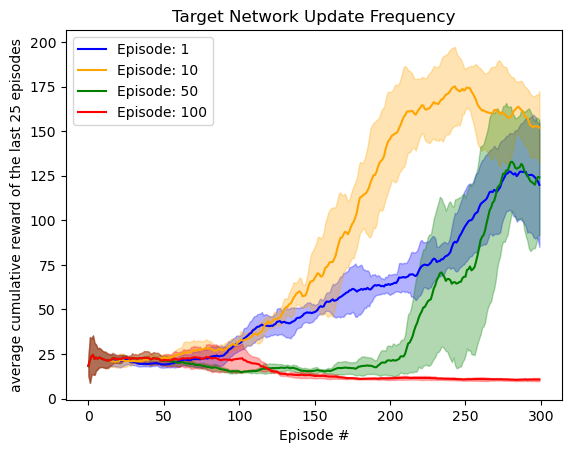

In [4]:
color = ['blue', 'orange', 'green', 'red']
updatefrequent = [1, 10, 50, 100]
for i in range(len(updatefrequent)):
    TARGET_UPDATE_FREQ = updatefrequent[i]
    # Train for different seeds
    curves = []
    for seed in SEEDS:
        curves += [train(seed)]
    label = "Episode: " + str(TARGET_UPDATE_FREQ)
    # Plot the curve for the given seeds
    plot_arrays(curves, color[i], label)

plt.legend(loc='best')
plt.title("Target Network Update Frequency")
plt.xlabel("Episode #")
plt.ylabel("average cumulative reward of the last 25 episodes")
plt.savefig('Part3_1.png', bbox_inches='tight')
plt.show()
plt.close()




TARGET_UPDATE_FREQ = 10

# Part3.2 Minibatch size
從圖表中的曲線可以看出minibatch的大小對學習效果同樣有顯著的影響：  
1. 當Mini-batch小的時候(藍線, size=1)，學習過程緩慢且不穩定，因為每次更新只使用一個樣本，使得計算出得梯度充滿雜訊，難以收斂到好的策略。  
2. 當Mini-batch大的時候 (紅線, size=100)，可看出學習速度和穩定性提升，因為一次使用多個樣本可以得到更準確的梯度估計，使得網路能夠快收斂到最佳策略。  
  
與精確梯度下降 (Exact Gradient Descent) 的關聯:  
精確梯度下降是使用整個訓練集來計算梯度，這種方法得到的梯度最準確，但計算成本極高。而mini-batch則是在在「計算效率」和「梯度估計準確性」之間取得的一個有效平衡。當mini-batch越大，其計算出的結果就越接近精確梯度。



Seed=1
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=1
Training:


R25(52.76): 100%|██████████| 300/300 [00:04<00:00, 60.94it/s] 


Training finished!
Seed=2
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=1
Training:


R25(44.84): 100%|██████████| 300/300 [00:04<00:00, 72.29it/s]  


Training finished!
Seed=3
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=1
Training:


R25(31.04): 100%|██████████| 300/300 [00:05<00:00, 55.36it/s]  


Training finished!
Seed=4
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=1
Training:


R25(34.2): 100%|██████████| 300/300 [00:07<00:00, 37.87it/s]   


Training finished!
Seed=5
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=1
Training:


R25(35.36): 100%|██████████| 300/300 [00:06<00:00, 47.74it/s]  


Training finished!
Seed=1
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=10
Training:


R25(156.72): 100%|██████████| 300/300 [00:21<00:00, 14.00it/s] 


Training finished!
Seed=2
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=10
Training:


R25(142.56): 100%|██████████| 300/300 [00:21<00:00, 13.90it/s] 


Training finished!
Seed=3
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=10
Training:


R25(153.84): 100%|██████████| 300/300 [00:20<00:00, 15.00it/s] 


Training finished!
Seed=4
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=10
Training:


R25(184.52): 100%|██████████| 300/300 [00:25<00:00, 11.98it/s] 


Training finished!
Seed=5
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=10
Training:


R25(122.04): 100%|██████████| 300/300 [00:22<00:00, 13.30it/s] 


Training finished!
Seed=1
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=50
Training:


R25(179.8): 100%|██████████| 300/300 [00:33<00:00,  8.91it/s]  


Training finished!
Seed=2
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=50
Training:


R25(193.76): 100%|██████████| 300/300 [00:31<00:00,  9.41it/s] 


Training finished!
Seed=3
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=50
Training:


R25(192.12): 100%|██████████| 300/300 [00:31<00:00,  9.66it/s] 


Training finished!
Seed=4
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=50
Training:


R25(174.12): 100%|██████████| 300/300 [00:31<00:00,  9.42it/s] 


Training finished!
Seed=5
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=50
Training:


R25(180.48): 100%|██████████| 300/300 [00:31<00:00,  9.47it/s] 


Training finished!
Seed=1
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=100
Training:


R25(173.08): 100%|██████████| 300/300 [00:33<00:00,  9.06it/s] 


Training finished!
Seed=2
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=100
Training:


R25(194.96): 100%|██████████| 300/300 [00:34<00:00,  8.76it/s] 


Training finished!
Seed=3
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=100
Training:


R25(198.16): 100%|██████████| 300/300 [00:34<00:00,  8.62it/s] 


Training finished!
Seed=4
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=100
Training:


R25(185.28): 100%|██████████| 300/300 [00:33<00:00,  8.96it/s] 


Training finished!
Seed=5
TARGET_UPDATE_FREQ=10
MINIBATCH_SIZE=100
Training:


R25(184.32): 100%|██████████| 300/300 [00:33<00:00,  9.05it/s] 


Training finished!


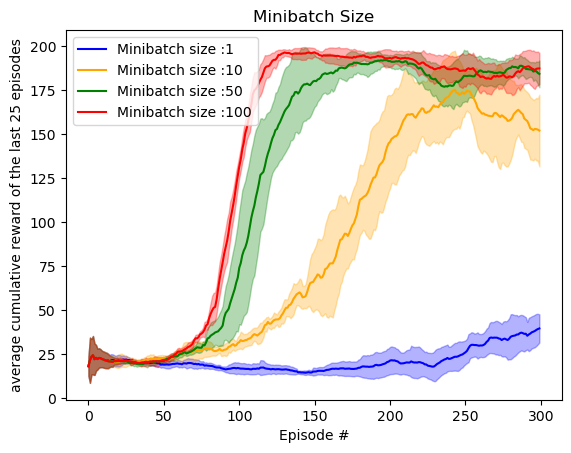

: 

In [ ]:
color = ['blue', 'orange', 'green', 'red']
minibatch = [1, 10, 50, 100]
for i in range(len(updatefrequent)):
    MINIBATCH_SIZE = updatefrequent[i]
    # Train for different seeds
    curves = []
    for seed in SEEDS:
        curves += [train(seed)]
    label = "Minibatch size :" + str(MINIBATCH_SIZE)
    # Plot the curve for the given seeds
    plot_arrays(curves, color[i], label)

plt.legend(loc='best')
plt.title("Minibatch Size")
plt.xlabel("Episode #")
plt.ylabel("average cumulative reward of the last 25 episodes")
plt.savefig('Part3_2.png', bbox_inches='tight')
plt.show()
plt.close()




MINIBATCH_SIZE = 10